import matplotlib.pyplot as plt
import statistics
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from sklearn.manifold import TSNE
# ^^^ pyforest auto-imports - don't write above this line
# Imports

In [264]:
import folium
from collections import Counter
import networkx as nx
import itertools
import time
import dijkstar
from OR_tools_tsp_solution import *
from create_data_model_or import *
%matplotlib inline
import random
import os
import copy
import glob
import numpy as np
import imageio
from PIL import Image

## My Data

In [2]:
stations_df = pd.read_csv("./saved_data/final_station_df.csv", index_col = 0)
non_unique_stations_df = pd.read_csv("./saved_data/non_unique_mta_stations.csv", index_col=0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
my_edgelist = pd.read_csv('./saved_data/edge_list_df_no_req.csv', index_col=0)
node_list_df = pd.read_csv("./saved_data/nodelist_nyc_subway.csv", index_col=0).reset_index()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Checking my data

In [4]:
# every node is in node_list_df
node1 = my_edgelist.node1.tolist()
node2 = my_edgelist.node2.tolist()

In [5]:
all_nodes_edgelist = set(node1 + node2)

In [6]:
for x in node_list_df['station_id']:
    if x not in all_nodes_edgelist:
        print(x)

## Visualizing my Data

In [7]:
g = nx.Graph()

In [8]:
for i, elrow in my_edgelist.iterrows():
    # g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())  # deprecated after NX 1.11
    g.add_edge(elrow[0], elrow[1], **elrow[2:].to_dict())

In [9]:
for i, nlrow in node_list_df.iterrows():
    nx.set_node_attributes(g, {nlrow['station_id']:  nlrow[1:].to_dict()})  

In [10]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))
# list(g.nodes(data=True))[0:2] 

# of edges: 542
# of nodes: 444


In [11]:
node_positions_as_dict = {x[0]: x[1] for x in list(g.nodes(data=True))}

In [12]:
node_positions_final = {key: value for key, value in node_positions_as_dict.items()}

### Checking for stops without coords

In [135]:
node_positions_final

True

In [17]:
node_positions = {node[0]: (node[1]['Y'], node[1]['X']) for node in list(g.nodes(data=True))}
# dict(list(node_positions.items())[0:5])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Graph Representation of NYC Subway Network')

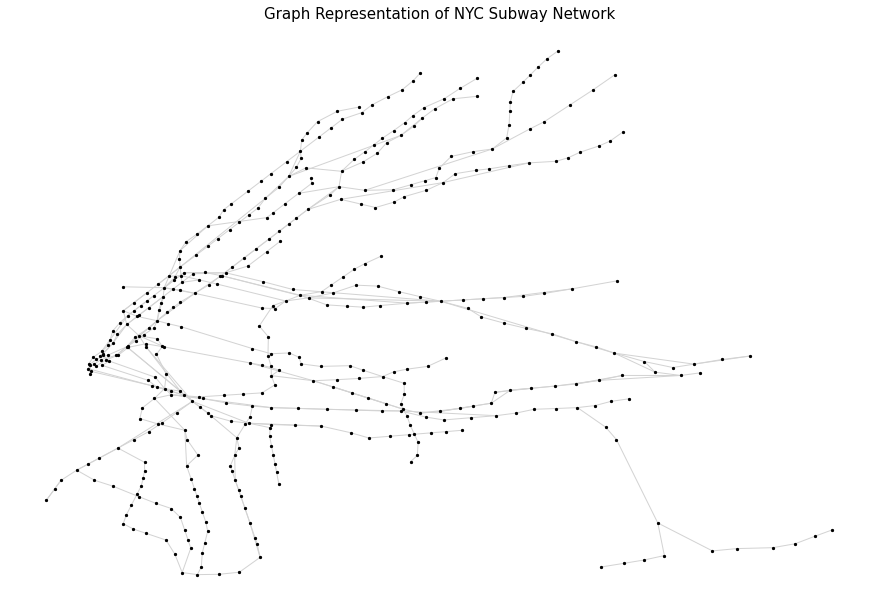

In [138]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='black')
plt.title('Graph Representation of NYC Subway Network', size=15)
# plt.savefig("./saved_data/graph_of_nyc_stops.png", bbox_inches='tight')

# Applying to All the Data

## Functions I will use

In [19]:
def get_indirect_distance(dijkstar_graph, nodelist):
    distance_matrix = []
    for i in range(len(nodelist)):
        start_node = nodelist['station_id'][i]
        one_node_tree = []
        for num in range(i, len(nodelist)):
            dest_node = nodelist['station_id'][num]
            path = dijkstar.find_path(dijkstar_graph, start_node, dest_node)
            path_distance = path.total_cost
            one_node_tree.append(path_distance)
        distance_matrix.append(one_node_tree)  # top right triangle of matrix
    for i in range(len(distance_matrix)):
        for x in range(i, len(distance_matrix)):
            if distance_matrix[i][x] != 0:
                distance_matrix[x].insert(i, distance_matrix[i][x])
    return distance_matrix

In [20]:
def get_time_in_hrs(seconds):
    minutes = seconds / 60
    hours = minutes / 60
    remainder_hour = hours % 1
    final_minutes = round((remainder_hour * 60), 2)
    return round(hours, 2), f"The entire route takes {hours - remainder_hour} hours, {final_minutes} minutes"

In [21]:
def tsp_station_ids(list_of_stops, nodelist, starting_stop = '101'):
    if starting_stop == '101':
        nodes = nodelist['station_id']
        list_of_nodes = [nodes[int(x)] for x in list_of_stops]
    elif starting_stop != '101':
        desired_row = nodelist[nodelist['station_id'] == starting_stop].index
        idx = [desired_row[0]] + [i for i in range(len(nodelist)) if i != desired_row]
        modified_nodelist = nodelist.iloc[idx].reset_index(drop=True)
        nodes = modified_nodelist['station_id']
        list_of_nodes = [nodes[int(x)] for x in list_of_stops]
    return list_of_nodes

In [22]:
def get_station_names(stations_df, tsp_station_ids):
    full_list = []
    for mta_station in tsp_station_ids:
        single_stations = mta_station.split("_")
        station_string = ""
        counter = 0
        for station in single_stations:
            row = stations_df.index[stations_df['stop_id'].str.contains(station)].tolist()
            for item in row:
                name = stations_df['stop_name'][item]
                if counter >= 1:
                    station_string += " / " + name
                    counter += 1
                elif counter == 0:
                    station_string += name
                    counter += 1
        full_list.append(station_string)
    return full_list

## Making Distance Matrix

### Original functions used

In [58]:
nyc_graph = dijkstar.Graph(undirected=True)
nyc_zipped_edges = list(zip(my_edgelist['node1'], my_edgelist['node2'], my_edgelist['distance']))
for x in nyc_zipped_edges:
    nyc_graph.add_edge(x[0], x[1], x[2])
nyc_dist_matrix = get_indirect_distance(nyc_graph, node_list_df)
matrix_station_zip = list(zip(node_list_df['station_id'], nyc_dist_matrix))
dist_matrix_dictionary = {key:value for key, value in matrix_station_zip}

### Loading Saved data

In [24]:
with open("./saved_data/Distance_matrix_as_dict.pickle", "rb") as f:
    nyc_dist_matrix_dict = pickle.load(f)

<IPython.core.display.Javascript object>

### Function to put desired station first 

In [25]:
def make_station_first_in_matrix(matrix_dict, desired_stations_id):
    new_dict = {desired_stations_id: matrix_dict[desired_stations_id]}
#     new_dict.update({desired_stations_id: matrix_dict[desired_stations_id]})
    for x in matrix_dict:
        if x not in new_dict:
            new_dict.update({x: matrix_dict[x]})
    return new_dict

### Turning Dict into matrix

In [26]:
def make_dict_a_matrix(dictionary):
    matrix_values = [value for value in dictionary.values()]
    return matrix_values

### Save Matrix Dict

In [27]:
# with open("./saved_data/Distance_matrix_as_dict.pickle", 'wb+') as f:
#     pickle.dump(orig_dist_matrix, f)

# Finding Fastest TSP by Starting Station 

## Making DataFrame

In [28]:
TSP_solutions_df = pd.DataFrame(columns = ['Starting_station', "Station_id_route", "Station_name_route",
                                          'Time_seconds', "Time_hours"])

<IPython.core.display.Javascript object>

## Formulas for adding to DataFrame

In [29]:
def shift_station_to_first_in_matrix(matrix_dict, desired_stations_id):
    index_value = list(matrix_dict.keys()).index(desired_stations_id)
    index_and_lower_keys = list(matrix_dict.keys())[index_value:]
    everything_shifted_dict = {key: value[index_value:]+value[:index_value] for key, value in matrix_dict.items()}
    # get the values for the matrix
    return_list = [value for key, value in everything_shifted_dict.items() if key in index_and_lower_keys]
    return_list2 = [value for key, value in everything_shifted_dict.items() if key not in index_and_lower_keys]
    return_list.extend(return_list2)
    # get the keys for each row 
    return_keys = [key for key, value in everything_shifted_dict.items() if key in index_and_lower_keys]
    return_keys2 = [key for key, value in everything_shifted_dict.items() if key not in index_and_lower_keys]
    return_keys.extend(return_keys2)
#     return_dict = {}
#     for key, value in everything_shifted_dict.items():
#         if key in index_and_lower_keys:
#             return_dict[key] =  value
#     for key, value in everything_shifted_dict.items():
#         if key not in index_and_lower_keys:
#             return_dict[key] =  value
    return return_list, return_keys

In [30]:
def list_of_tsp_station_ids(stop_list, stop_dict_keys):
    station_ids_in_order = []
#     stop_dict_keys = list(stop_dict.keys())
    for x in stop_list[:-1]:
        station_ids_in_order.append(stop_dict_keys[int(x)])
    station_ids_in_order.append(stop_dict_keys[0])
    return station_ids_in_order

In [31]:
# https://github.com/google/or-tools/issues/1260
def run_or_tools(dist_matrix):
    data_model = create_data_model(dist_matrix)
    seconds, list_of_stops = tsp(data_model)
    return seconds, list_of_stops

In [32]:
def results_to_df(original_stop, stations_df=non_unique_stations_df, nodelistdf=node_list_df,
                  dist_matrix_dict=nyc_dist_matrix_dict, final_df=TSP_solutions_df):
    stop_dict = make_station_first_in_matrix(dist_matrix_dict, original_stop)
    stop_dist_matrix = make_dict_a_matrix(stop_dict)
    time, stop_list = run_or_tools(stop_dist_matrix)
    time_in_hours, time_message = get_time_in_hrs(time)
    tsp_stations = tsp_station_ids(stop_list, nodelistdf, starting_stop=original_stop)
    station_names = get_station_names(stations_df, tsp_stations)
    data = [original_stop, tsp_stations, station_names, time, time_in_hours]
#     data_as_series = pd.Series(data, index = final_df.columns)
#     final_df = final_df.append(pd.DataFrame([data], columns = final_df.columns), ignore_index=True, 
#                                verify_integrity=True)
    if original_stop not in list(final_df.Starting_station):
        final_df.loc[len(final_df)] = data
    return final_df

In [33]:
def results_to_df2(original_stop, stations_df=non_unique_stations_df,
                  dist_matrix_dict=nyc_dist_matrix_dict, final_df=TSP_solutions_df):
    stop_dist_matrix, stop_dist_keys = shift_station_to_first_in_matrix(dist_matrix_dict, original_stop)
    time, stop_list = run_or_tools(stop_dist_matrix)
    time_in_hours, time_message = get_time_in_hrs(time)
    tsp_stations = list_of_tsp_station_ids(stop_list, stop_dist_keys)
    station_names = get_station_names(stations_df, tsp_stations)
    data = [original_stop, tsp_stations, station_names, time, time_in_hours]
    if original_stop not in list(final_df.Starting_station):
        final_df.loc[len(final_df)] = data
    return final_df

## Choosing which stations to test

### Geographic center

In [34]:
lat_mean = node_list_df.X.mean()
lon_mean = node_list_df.Y.mean()

In [35]:
absolute_difference_function = lambda list_value : abs(list_value[0] - lat_mean) + abs(list_value[1] - lon_mean)
closest_values = min(list(zip(node_list_df['X'], node_list_df['Y'])), key=absolute_difference_function)

In [36]:
closest_values

(40.744587, -73.93099699999998)

In [37]:
node_list_df[(node_list_df['X'] == closest_values[0]) & (node_list_df['Y'] == closest_values[1])]

,station_id,X,Y
165,716,40.744587,-73.930997


In [38]:
non_unique_stations_df[non_unique_stations_df['stop_id'].str.contains('716')]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
504,716,33 St,40.744587,-73.930997,1,NaN


#### Running Formulas

In [39]:
TSP_solutions_df = results_to_df2('716')

Objective: 73020 miles


### Most Connections

#### Finding most_connected Stations

In [40]:
all_nodes_edglist_list = node1 + node2
node_count_dict = {i: all_nodes_edglist_list.count(i) for i in all_nodes_edgelist}
max(list(node_count_dict.values()))

10

#### Appears 10 times

In [41]:
most_connected_station = [k for k, v in Counter(node_count_dict.items()) if v > 9]
most_connected_station

['635_L03_R20']

In [42]:
non_unique_stations_df[non_unique_stations_df['stop_id'].str.contains("635")]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
447,635,14 St - Union Sq,40.734673,-73.989951,1,NaN


##### Solving it

In [43]:
TSP_solutions_df = results_to_df2("635_L03_R20")

Objective: 72570 miles


#### Appears 9 times

In [44]:
most_connected_station_9 = [k for k, v in Counter(node_count_dict.items()) if v == 9]
most_connected_station_9

['127_725_902_R16', '235_D24_R31']

In [45]:
non_unique_stations_df[non_unique_stations_df['stop_id'].str.contains("127")]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
72,127,Times Sq - 42 St,40.75529,-73.987495,1,NaN


In [46]:
non_unique_stations_df[non_unique_stations_df['stop_id'].str.contains("235")]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
210,235,Atlantic Av - Barclays Ctr,40.684359,-73.977666,1,NaN


##### Running formulas 

In [48]:
TSP_solutions_df = results_to_df2("127_725_902_R16") # times sq
TSP_solutions_df = results_to_df2("235_D24_R31") # barclays centr

Objective: 74460 miles
Objective: 72360 miles


### Edge nodes (control)

#### Far Rockaway

In [49]:
# starting from what I hypothesize to be the worst place to start and end the subway challenge from
non_unique_stations_df[non_unique_stations_df['stop_name'].str.contains("Far Rockaway")]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
1071,H11,Far Rockaway - Mott Av,40.603995,-73.755405,1,NaN


In [51]:
TSP_solutions_df = results_to_df2("H11")
# TSP_solutions_df.loc[4] = data_rockaway

Objective: 71820 miles


#### Pelham Bay

In [52]:
# starting from what I hypothesize to be the worst place to start and end the subway challenge from
non_unique_stations_df[non_unique_stations_df['stop_name'].str.contains("Pelham Bay")]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
351,601,Pelham Bay Park,40.852462,-73.828121,1,NaN


In [53]:
TSP_solutions_df = results_to_df2("601")
# TSP_solutions_df.loc[5] = data_pelham

Objective: 73560 miles


In [54]:
TSP_solutions_df

,Starting_station,Station_id_route,Station_name_route,Time_seconds,Time_hours
0,716,"[716, 715, 714, 713, 712, 711, B04, B06, B08, ...","[33 St, 40 St, 46 St, 52 St, Woodside - 61 St,...",73020,20.28
1,635_L03_R20,"[635_L03_R20, L02, L01_A31, A30, A28, A27, A25...",[14 St - Union Sq / Union Sq - 14 St / 14 St -...,72570,20.16
2,127_725_902_R16,"[127_725_902_R16, 126, R15, R14, R13, R11, R01...",[Times Sq - 42 St / Times Sq - 42 St / Times S...,74460,20.68
3,235_D24_R31,"[235_D24_R31, 236, 237, 238, 239, 248, 249, 25...",[Atlantic Av - Barclays Ctr / Atlantic Av - Ba...,72360,20.10
4,H11,"[H11, H10, H09, H08, H07, H06, H04_H19, H12, H...","[Far Rockaway - Mott Av, Beach 25 St, Beach 36...",71820,19.95
5,601,"[601, 602, 603, 604, 606, 607, 608, 609, 610, ...","[Pelham Bay Park, Buhre Av, Middletown Rd, Wes...",73560,20.43


## Choosing up to 20 random stations

In [55]:
# generating 50 random numbers
random_nums = []
x = 0
while x < 20:
    new_num = random.randint(0, len(node_list_df))
    random_nums.append(new_num)
    x += 1

In [56]:
for x in random_nums:
    station_name = node_list_df.iloc[x]['station_id']
    if station_name not in list(TSP_solutions_df.Starting_station):
        TSP_solutions_df = results_to_df2(station_name)

Objective: 71880 miles
Objective: 71640 miles
Objective: 72840 miles
Objective: 72570 miles
Objective: 75780 miles
Objective: 75150 miles
Objective: 72300 miles
Objective: 71520 miles
Objective: 71340 miles
Objective: 71820 miles
Objective: 72000 miles
Objective: 72600 miles
Objective: 73830 miles
Objective: 72720 miles
Objective: 71190 miles
Objective: 75930 miles
Objective: 72450 miles
Objective: 72810 miles
Objective: 71160 miles


In [57]:
TSP_solutions_df.sort_values(by='Time_seconds')

,Starting_station,Station_id_route,Station_name_route,Time_seconds,Time_hours
24,R42,"[R42, R43, R44, R41, N02, N03, N04, N05, N06, ...","[Bay Ridge Av, 77 St, 86 St, 59 St, 8 Av, Fort...",71160,19.77
20,214,"[214, 213, 212, 211, 210, 209, 208, 207, 206, ...","[West Farms Sq - E Tremont Av, E 180 St, Bronx...",71190,19.77
14,G19,"[G19, G18, G16, G15, 711, 710_G14, 709, 708, 7...","[Steinway St, 46 St, Northern Blvd, 65 St, 69 ...",71340,19.82
13,D15,"[D15, B10, B08, Q03, Q04, Q05, B06, B04, 710_G...","[47-50 Sts - Rockefeller Ctr, 57 St, Lexington...",71520,19.87
7,402,"[402, 405, 406, 407, 408, 409, 410, 411, 412, ...","[Mosholu Pkwy, Bedford Park Blvd - Lehman Coll...",71640,19.90
15,H10,"[H10, H11, H09, H08, H07, H06, H04_H19, H12, H...","[Beach 25 St, Far Rockaway - Mott Av, Beach 36...",71820,19.95
4,H11,"[H11, H10, H09, H08, H07, H06, H04_H19, H12, H...","[Far Rockaway - Mott Av, Beach 25 St, Beach 36...",71820,19.95
6,A63,"[A63, A61, A60, A59, A57, A55, A54, A53, A52, ...","[104 St, Rockaway Blvd, 88 St, 80 St, Grant Av...",71880,19.97
16,D14,"[D14, F12, F11, 719_F09_G22, G24, G26, G28, G2...","[7 Av, 5 Av/53 St, Lexington Av/53 St, Court S...",72000,20.00
12,B23,"[B23, B22, B21, B20, B19, B18, B17, B16, B15, ...","[Bay 50 St, 25 Av, Bay Pkwy, 20 Av, 18 Av, 79 ...",72300,20.08


# Plotting Stations 

In [104]:
base_map = folium.folium.Map([40.7128, -74.0061], zoom_start=10, tiles='cartodbpositron') # city hall coords

## Getting all coordinates for TSP_solutions_df

In [91]:
tsp_station_coords = []
for x in range(len(TSP_solutions_df)):
    station = TSP_solutions_df['Starting_station'][x]
    station_index = list(node_list_df['station_id']).index(station)
    station_coords = [node_list_df['X'][station_index], node_list_df['Y'][station_index]]
    tsp_station_coords.append(station_coords)

In [109]:
for idx, coord in enumerate(tsp_station_coords):
    if TSP_solutions_df['Time_hrs_no_return'][idx] < 19.75:
        folium.Circle(
            location = (coord[0], coord[1]),
            radius = 100, 
            popup = coord,
            color='green',
            fill=False,
        ).add_to(base_map)
    else:
        folium.Circle(
                location = (coord[0], coord[1]),
                radius = 100, 
                popup = coord,
                color='crimson',
                fill=False,
            ).add_to(base_map)

In [110]:
# looks like some of the outer stations work best
base_map

# Checking Every station

In [120]:
# TSP_solutions_df.drop(columns=['Time_sec_no_return', 'Time_hrs_no_return'], inplace=True)

In [122]:
# about 3 seconds per station, 400 stations
for x in range(len(node_list_df)):
    station_name = node_list_df['station_id'][x]
    if station_name not in list(TSP_solutions_df.Starting_station):
        TSP_solutions_df = results_to_df2(station_name)

Objective: 71070 miles
Objective: 71070 miles
Objective: 71070 miles
Objective: 71070 miles
Objective: 72030 miles
Objective: 71070 miles
Objective: 71070 miles
Objective: 71070 miles
Objective: 71070 miles
Objective: 73890 miles
Objective: 71070 miles
Objective: 72990 miles
Objective: 73320 miles
Objective: 72660 miles
Objective: 72930 miles
Objective: 72930 miles
Objective: 71520 miles
Objective: 71520 miles
Objective: 71880 miles
Objective: 75150 miles
Objective: 72480 miles
Objective: 74970 miles
Objective: 74970 miles
Objective: 72720 miles
Objective: 73020 miles
Objective: 75570 miles
Objective: 75570 miles
Objective: 75570 miles
Objective: 75570 miles
Objective: 75570 miles
Objective: 75570 miles
Objective: 73290 miles
Objective: 72570 miles
Objective: 74640 miles
Objective: 72570 miles
Objective: 75210 miles
Objective: 72570 miles
Objective: 72900 miles
Objective: 72900 miles
Objective: 72210 miles
Objective: 72900 miles
Objective: 72900 miles
Objective: 72900 miles
Objective: 

Objective: 73770 miles
Objective: 73770 miles
Objective: 73770 miles
Objective: 73410 miles
Objective: 73410 miles
Objective: 72630 miles
Objective: 73410 miles
Objective: 74670 miles
Objective: 74790 miles
Objective: 74670 miles
Objective: 72720 miles
Objective: 72870 miles
Objective: 72990 miles
Objective: 73020 miles
Objective: 73740 miles
Objective: 72810 miles
Objective: 72360 miles
Objective: 74610 miles
Objective: 73620 miles
Objective: 74220 miles
Objective: 71760 miles
Objective: 74220 miles
Objective: 74220 miles
Objective: 74220 miles
Objective: 72990 miles
Objective: 73380 miles
Objective: 73200 miles
Objective: 73080 miles
Objective: 71730 miles
Objective: 71730 miles
Objective: 71730 miles
Objective: 71790 miles
Objective: 71790 miles
Objective: 71790 miles
Objective: 71790 miles
Objective: 71790 miles
Objective: 71790 miles
Objective: 73560 miles
Objective: 72750 miles
Objective: 71910 miles
Objective: 73200 miles
Objective: 72810 miles
Objective: 71040 miles
Objective: 

In [129]:
os.system('say "your program has finished"')

0

#### Calculating time to reach all stations without returning home

In [125]:
non_returning_time_in_seconds = []
for x in range(len(TSP_solutions_df)):
    id_route = TSP_solutions_df['Station_id_route'][x]
    original_time = TSP_solutions_df['Time_seconds'][x]
    path = dijkstar.find_path(nyc_graph, id_route[-2], id_route[-1])
    path_distance = path.total_cost
    new_time = original_time - path_distance
    non_returning_time_in_seconds.append(new_time)

In [126]:
TSP_solutions_df['Time_sec_no_return'] = non_returning_time_in_seconds
non_returning_time_in_hrs = [get_time_in_hrs(x)[0] for x in non_returning_time_in_seconds]
TSP_solutions_df['Time_hrs_no_return'] = non_returning_time_in_hrs

In [132]:
TSP_solutions_df.sort_values(by='Time_sec_no_return', ascending=False).head(7)

,Starting_station,Station_id_route,Station_name_route,Time_seconds,Time_hours,Time_sec_no_return,Time_hrs_no_return
306,F31,"[F31, F32, F33, F34, F35, F36, F38, F39, D42, ...","[Avenue I, Bay Pkwy, Avenue N, Avenue P, Kings...",75780,21.05,75720,21.03
307,F32,"[F32, F33, F34, F35, F36, F38, F39, D42, D41, ...","[Bay Pkwy, Avenue N, Avenue P, Kings Hwy, Aven...",75780,21.05,75720,21.03
10,F27,"[F27, F29, F30, F31, F32, F33, F34, F35, F36, ...","[Church Av, Ditmas Av, 18 Av, Avenue I, Bay Pk...",75780,21.05,75690,21.02
305,F30,"[F30, F31, F32, F33, F34, F35, F36, F38, F39, ...","[18 Av, Avenue I, Bay Pkwy, Avenue N, Avenue P...",75780,21.05,75660,21.02
304,F29,"[F29, F30, F31, F32, F33, F34, F35, F36, F38, ...","[Ditmas Av, 18 Av, Avenue I, Bay Pkwy, Avenue ...",75780,21.05,75660,21.02
164,637,"[637, 638, 639, 640, 418, 419, 420, 232_423, 2...","[Bleecker St, Spring St, Canal St, Brooklyn Br...",75660,21.02,75570,20.99
167,640,"[640, 418, 419, 420, 232_423, 231, 233, 234, 2...","[Brooklyn Bridge - City Hall, Fulton St, Wall ...",75660,21.02,75540,20.98


In [133]:
TSP_solutions_df.sort_values(by='Time_seconds', ascending=False).head(7)

,Starting_station,Station_id_route,Station_name_route,Time_seconds,Time_hours,Time_sec_no_return,Time_hrs_no_return
355,J20,"[J20, J21, J22, J23, J24, L22_J27, L21, L20, L...","[Crescent St, Norwood Av, Cleveland St, Van Si...",75990,21.11,74940,20.82
353,J17,"[J17, J16, J19, J20, J21, J22, J23, J24, L22_J...","[75 St, 85 St - Forest Pkwy, Cypress Hills, Cr...",75960,21.10,74760,20.77
357,J22,"[J22, J21, J23, J24, L22_J27, L21, L20, L19, L...","[Cleveland St, Norwood Av, Van Siclen Av, Alab...",75930,21.09,75030,20.84
21,J24,"[J24, J21, J22, J23, L22_J27, L21, L20, L19, L...","[Alabama Av, Norwood Av, Cleveland St, Van Sic...",75930,21.09,75180,20.88
306,F31,"[F31, F32, F33, F34, F35, F36, F38, F39, D42, ...","[Avenue I, Bay Pkwy, Avenue N, Avenue P, Kings...",75780,21.05,75720,21.03
10,F27,"[F27, F29, F30, F31, F32, F33, F34, F35, F36, ...","[Church Av, Ditmas Av, 18 Av, Avenue I, Bay Pk...",75780,21.05,75690,21.02
304,F29,"[F29, F30, F31, F32, F33, F34, F35, F36, F38, ...","[Ditmas Av, 18 Av, Avenue I, Bay Pkwy, Avenue ...",75780,21.05,75660,21.02


## Saving df 

In [131]:
# TSP_solutions_df.to_csv("./saved_data/TSP_solutions_df.csv")

# Visualizing Route 

## Simplified Route Gif

In [160]:
# this is simplified: it doesn't include intermediary steps between stations
h11_route = TSP_solutions_df['Station_id_route'][4]

In [161]:
g_i = nx.Graph(undirected=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(-74.04204765, -73.74175535000002, 40.5597771, 40.919474900000004)

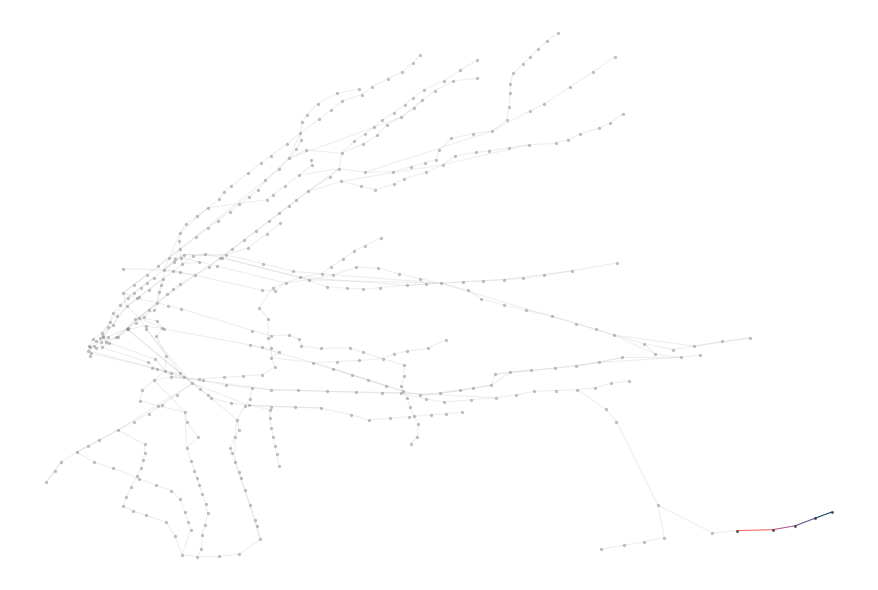

In [233]:
plt.figure(figsize=(12, 8))
nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='gray', alpha=0.4)
g_i.add_edge(h11_route[0], h11_route[1])
g_i.add_edge(h11_route[1], h11_route[2])
g_i.add_edge(h11_route[2], h11_route[3])
g_i.add_edge(h11_route[3], h11_route[4])
edge_color_list = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600"]
nx.draw_networkx_nodes(g_i, pos=node_positions, node_size=6, alpha=0.6, node_color='black', with_labels=False, linewidths=0.1)
nx.draw_networkx_edges(g_i, pos=node_positions, edge_color=edge_color_list, alpha=1, linewidths=0.1)
plt.axis('off')
# plt.savefig('./H11_route_images/test.png'.format(i), dpi=120, bbox_inches='tight')
# plt.close()

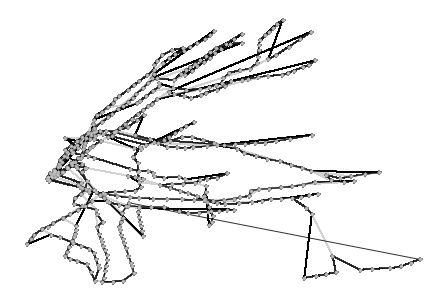

In [263]:
## special thanks to code template found here: http://brooksandrew.github.io/simpleblog/articles/intro-to-graph-optimization-solving-cpp/#cpp-solution
# colors from https://learnui.design/tools/data-color-picker.html
# visit_colors = {1:"#003f5c", 2:"#58508d", 3:"#bc5090", 4:"#ff6361", 5:"#ffa600"}
# edge_counter = {}
# g_i_edge_colors = []
for i, e in enumerate(h11_route[:-1]):
    edge = frozenset([e, h11_route[i+1]])
#     if edge in edge_counter:
#         edge_counter[edge] += 1
#     else:
#         edge_counter[edge] = 1
    # Full graph (faded in background)
    nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='gray', alpha=0.4)

    # Edges walked as of iteration i
    h11_route_x = copy.deepcopy(h11_route[0:i+2])
    g_x = nx.Graph()
    for x in range(i+1):
        edge_x = frozenset([h11_route_x[x], h11_route_x[x+1]])
        g_x.add_edge(h11_route_x[x], h11_route_x[x+1])
#         euler_circuit_i[i][2]['visits_i'] = edge_counter[edge_i]
#     g_i = nx.Graph(euler_circuit_i)
#     g_i_edge_colors = [visit_colors[e[2]['visits_i']] for e in g_i.edges(data=True)]

    nx.draw_networkx_nodes(g_x, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=False, linewidths=0.1)
    nx.draw_networkx_edges(g_x, pos=node_positions, edge_color='black', alpha=0.8)

#     plt.axis('off')
#     plt.savefig('H11_route_images_simplified/img{}.png'.format(i), dpi=120, bbox_inches='tight')
#     plt.close()

In [254]:
os.system('say "your program has finished"')

0

In [257]:
# gif 
def make_circuit_video(image_path, movie_filename, fps=5):
    # sorting filenames in order
    filenames = glob.glob(image_path + 'img*.png')
    filenames_sort_indices = np.argsort([int(os.path.basename(filename).split('.')[0][3:]) for filename in filenames])
    filenames = [filenames[i] for i in filenames_sort_indices]

    # make movie
    with imageio.get_writer(movie_filename, mode='I', fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

In [260]:
# make_circuit_video('H11_route_images/', 'H11_route_images_simplified/tsp_route_animation.gif', fps=5)
# to view this: click on file in finder and hit space bar
## compress using https://ezgif.com/optimize/ezgif-2-c87090f2fc86.gif
# to view in python, use this link https://stackoverflow.com/questions/28518072/play-animations-in-gif-with-tkinter

## More Complicated Gif

In [ ]:
## special thanks to code template found here: http://brooksandrew.github.io/simpleblog/articles/intro-to-graph-optimization-solving-cpp/#cpp-solution
# colors from https://learnui.design/tools/data-color-picker.html
# visit_colors = {1:"#003f5c", 2:"#58508d", 3:"#bc5090", 4:"#ff6361", 5:"#ffa600"}
## new set of colors
#2b4200
#4e6422
#738844
#9aae66
#c3d68a
#edffb0
# edge_counter = {}
# g_i_edge_colors = []
for i, e in enumerate(h11_route[:-1]):
    edge = frozenset([e, h11_route[i+1]])
#     if edge in edge_counter:
#         edge_counter[edge] += 1
#     else:
#         edge_counter[edge] = 1
    # Full graph (faded in background)
    nx.draw(g, pos=node_positions, edge_color='lightgrey', node_size=5, node_color='gray', alpha=0.4)

    # Edges walked as of iteration i
    h11_route_x = copy.deepcopy(h11_route[0:i+2])
    g_x = nx.Graph()
    for x in range(i+1):
        edge_x = frozenset([h11_route_x[x], h11_route_x[x+1]])
        g_x.add_edge(h11_route_x[x], h11_route_x[x+1])
#         euler_circuit_i[i][2]['visits_i'] = edge_counter[edge_i]
#     g_i = nx.Graph(euler_circuit_i)
#     g_i_edge_colors = [visit_colors[e[2]['visits_i']] for e in g_i.edges(data=True)]

    nx.draw_networkx_nodes(g_x, pos=node_positions, node_size=6, alpha=0.6, node_color='lightgray', with_labels=False, linewidths=0.1)
    nx.draw_networkx_edges(g_x, pos=node_positions, edge_color='black', alpha=0.8)

#     plt.axis('off')
#     plt.savefig('H11_route_images/img{}.png'.format(i), dpi=120, bbox_inches='tight')
#     plt.close()